# Load environment

In [1]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

api_key="sk...."

chat_model = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)
evaluator_llm = LangchainLLMWrapper(chat_model)
evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-large", api_key=api_key))

In [ ]:
!pip install langchain_chroma python-magic langchain_huggingface pypdf

In [2]:
# Setup temporary Chroma
import chromadb
import os
from chromadb.config import Settings
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from app.ai_conversation.file_handling.vectorstore import set_chroma

client = chromadb.HttpClient(
    host=os.getenv("CHROMA_HOST", "localhost"),
    port=os.getenv("CHROMA_PORT", "6002"),
    settings=Settings(
        chroma_client_auth_provider="chromadb.auth.token_authn.TokenAuthClientProvider",
        chroma_client_auth_credentials=os.getenv("CHROMA_TOKEN", "test-token"),
    ),
)
# Clean up, when last time it was used...
client.delete_collection("test")
sentence_transformer_ef = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
chroma = Chroma(
    client=client,
    collection_name="test",
    embedding_function=sentence_transformer_ef,
    collection_metadata={"hnsw:space": "cosine"},
)
set_chroma(chroma)

/home/ruben/anaconda3/envs/langchain-training/lib/python3.13/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Insert a script (file/files)

In [ ]:
!pip install git+https://github.com/brandonstarxel/chunking_evaluation.git

In [3]:
from app.ai_conversation.file_handling.vectorstore import import_to_vectorstore
from app.ai_conversation.entities.uploaded_file_content import UploadedFileContent
from uuid import UUID, uuid4
import time

paths = [
    "./eval/skript.pdf"
]

files = []
docs = []
input_times = []
for path in paths:
    temp_file = UploadedFileContent(
        id=uuid4(),
        hash="irrelevant",
        file_ref=uuid4(),
        unprocessed=True,
    )
    before = time.perf_counter()
    res = await import_to_vectorstore(temp_file, custom_path=path)
    after = time.perf_counter()
    if type(res) == list:
        files.append(temp_file)
        docs.extend(res)
        input_times.append(after - before)

print(f"Uploaded {len(files)} files, {len(docs)} docs")

Inserting 3219 documents for 6cd29c8a-823b-4b13-a8f6-9ca16cdea287 with custom path
Uploaded 1 files, 296 docs


In [4]:
collection = client.get_collection("test")
print(f"There are a total of {collection.count()} chunks inside the vectorstore")
print(input_times)

There are a total of 1570 chunks inside the vectorstore
[330.7996016999823]


## Generate a test dataset

In [ ]:
!pip install rapidfuzz

In [ ]:
from ragas.testset import TestsetGenerator
generator = TestsetGenerator(llm=evaluator_llm, embedding_model=evaluator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=150)

## Save or load Dataset

In [5]:
import pandas as pd
file_name = 'eval/test_dataset.pkl'
if 'dataset' in vars():
    dataFrame = dataset.to_pandas()
    dataFrame.to_pickle(file_name)
else:
    dataFrame = pd.read_pickle(file_name)
dataFrame

,user_input,reference_contexts,reference,synthesizer_name
0,Was ist ein Bipolartransistor und warum ist es...,[Inhaltsverzeichnis 1 Geschichte der Informati...,Der Bipolartransistor ist ein Halbleiterbauele...,single_hop_specifc_query_synthesizer
1,What are the key historical developments in In...,[Inhaltsverzeichnis 1 Geschichte der Informati...,The key historical developments in Informatik ...,single_hop_specifc_query_synthesizer
2,What is the significance of the Internet in th...,[Inhaltsverzeichnis 1 Geschichte der Informati...,The Internet is a crucial topic in the history...,single_hop_specifc_query_synthesizer
3,Was ist Internet und warum wichtig?,[Inhaltsverzeichnis 1 Geschichte der Informati...,Im Kontext der Informatik ist das Internet ein...,single_hop_specifc_query_synthesizer
4,Was ist Analog- und Digitaltechnik?,[Inhaltsverzeichnis 1 Geschichte der Informati...,"Analog- und Digitaltechnik ist ein Thema, das ...",single_hop_specifc_query_synthesizer
...,...,...,...,...
66,Wht is the Intel 8086 processor and how does i...,[<1-hop>\n\nviii INHALTSVERZEICHNIS 12 Prozess...,The Intel 8086 processor is a key component of...,multi_hop_specific_query_synthesizer
67,What is the significance of the Intel 8086 pro...,[<1-hop>\n\nviii INHALTSVERZEICHNIS 12 Prozess...,The Intel 8086 processor is significant as it ...,multi_hop_specific_query_synthesizer
68,What are the key features of the Intel 8086 pr...,[<1-hop>\n\nviii INHALTSVERZEICHNIS 12 Prozess...,The Intel 8086 processor is a significant comp...,multi_hop_specific_query_synthesizer
69,What are the key features of the Intel 8086 pr...,[<1-hop>\n\nviii INHALTSVERZEICHNIS 12 Prozess...,The Intel 8086 processor is a significant comp...,multi_hop_specific_query_synthesizer


## Define retrieve and query

In [6]:
#from langchain.retrievers import ContextualCompressionRetriever
#from langchain_community.document_compressors import LLMLinguaCompressor
#compressor = LLMLinguaCompressor(model_name="openai-community/gpt2", device_map="cpu")
async def query_for(query, files, k=7, score_threshold=0.1):
    def _message_to_str(message):
        if isinstance(message.content, str):
            return message.content
        text = ""
        for x in message.content:
            if isinstance(x, str):
                text += x + "\n"
            elif isinstance(x, dict) and "text" in x:
                text += x["text"] + "\n"
        return text

    retriever = chroma.as_retriever(
        search_type="similarity_score_threshold",
        search_kwargs={
            "score_threshold": score_threshold,
            "k": k,
        },
        filter={"ref_id": {"$in": [f.file_ref for f in files]}},
    )
    #retriever = ContextualCompressionRetriever(
    #    base_compressor=compressor, base_retriever=retriever
    #)
    return await retriever.ainvoke(_message_to_str(query))

In [7]:
from langchain_core.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    MessagesPlaceholder,
)

rag_template = SystemMessagePromptTemplate.from_template(
    """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
Always add citations whenever possible in the form of †[document_id]† at the end of a paragraph, inside the text, or at the end of the answer.
When you use information from multiple documents, cite them in the order they appear, like this: †[document_id_1]† †[document_id_2]†.
Even when the answer is based on general knowledge or reasoning, include citations from relevant documents whenever applicable.
If you don't know the answer, just say that you don't know. Keep the answer concise and always respond in the user's language.

Context: {context}"""
)

prompt = ChatPromptTemplate.from_messages(
    [
        MessagesPlaceholder(variable_name="system_messages"),
        MessagesPlaceholder(variable_name="question"),
    ]
)
async def qa(documents, query):    
    def format_docs(docs):
        unwanted_keys = ["ref_id", "id"]
        return "\n\n".join(
            f"†[{doc.metadata['id']}, { {x: doc.metadata[x] for x in doc.metadata if x not in unwanted_keys} }]†:\n{doc.page_content}"
            for doc in docs
        )
    system_messages = [rag_template.format(context=format_docs(documents))]
    chain = prompt | chat_model
    return await chain.ainvoke(
        {
            "question": [query],
            "system_messages": system_messages,
        }
    )

async def run(query):
    docs = await query_for(query, files)
    for d in docs:
        if 'id' not in d.metadata:
            d.metadata['id'] = str(uuid4())
    response = await qa(docs, query)
    return docs, response

async def run_normal(query):
    return await chat_model.ainvoke([query])


In [8]:
from langchain_core.messages import HumanMessage
from tqdm.notebook import tqdm
import time

data = []
times = []
length = len(dataFrame["user_input"])
for i in tqdm(range(length)):
    x = dataFrame["user_input"][i]
    before = time.perf_counter()
    m = await run(HumanMessage(x))
    after = time.perf_counter()
    data.append(m)
    times.append(after - before)
print(len(data))

  0%|          | 0/71 [00:00<?, ?it/s]

71


Min: 1.9484315949957818, Max: 14.854187346994877, Mean: 4.793710863719445, Median: 4.346196834987495, Variance: 4.703318374487095, Skew: 1.8123151271740308


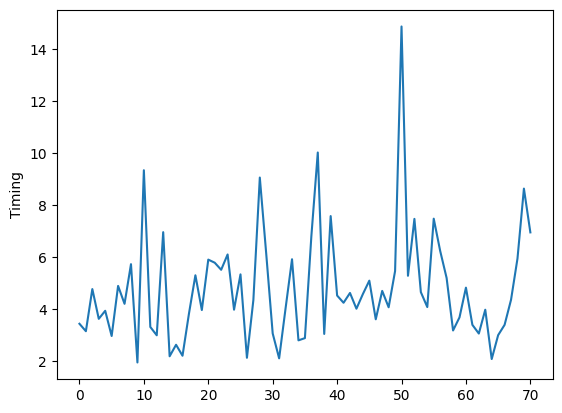

In [9]:
from statistics import mean, median, variance
from scipy.stats import skew
import matplotlib.pyplot as plt

print(f"Min: {min(times)}, Max: {max(times)}, Mean: {mean(times)}, Median: {median(times)}, Variance: {variance(times)}, Skew: {skew(times)}")


plt.plot(times)
plt.ylabel('Timing')
plt.show()

In [9]:
from ragas import EvaluationDataset
import re

def substiute_refs(output, docs):
    regex = r"†\[[^†]*\]†"
    content = output.content
    new_str = ""
    last_index = 0
    matches = re.finditer(regex, content, re.MULTILINE)
    for matchNum, match in enumerate(matches, start=1):
        d_id = match.group()[2:match.group().index(",")]
        new_str += content[last_index:match.start()]
        for i, d in enumerate(docs):
            if d.id == d_id:
                new_str += f"[{i}]"
                break
        last_index = match.end()
    new_str += content[last_index:]
    return new_str

evaluation_dataset = EvaluationDataset.from_list(
    [
        {
            "user_input": dataFrame["user_input"][i],
            "retrieved_contexts": [d.page_content for d in data[i][0]],
            "response": substiute_refs(data[i][1], data[i][0]),
            "reference": dataFrame["reference"][i],
        } for i in range(length)
    ]
)

## Generate samples

In [10]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, LLMContextPrecisionWithoutReference, LLMContextPrecisionWithReference, ResponseRelevancy, FaithfulnesswithHHEM
from ragas import evaluate

rr_scorer = ResponseRelevancy(name="answer_relevancy", llm=evaluator_llm, embeddings=evaluator_embeddings)
prec_ref_scorer = LLMContextPrecisionWithReference(name="precision_ref", llm=evaluator_llm)
prec_scorer = LLMContextPrecisionWithoutReference(name="precision", llm=evaluator_llm)
recall_scorer = LLMContextRecall(name="recall", llm=evaluator_llm)
ff_scorer = Faithfulness(name="faithfulness", llm=evaluator_llm)
ff_2_scorer = FaithfulnesswithHHEM(name="faithfulness_hhem", device="cpu", batch_size=10)
fc_scorer =  FactualCorrectness(name="factual_correctness", llm=evaluator_llm)

results = evaluate(evaluation_dataset, metrics=[rr_scorer, prec_ref_scorer, prec_scorer, recall_scorer, ff_scorer, ff_2_scorer, fc_scorer], llm=evaluator_llm)
results

You are using a model of type HHEMv2Config to instantiate a model of type HHEMv2. This is not supported for all configurations of models and can yield errors.


Evaluating:   0%|          | 0/497 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (782 > 512). Running this sequence through the model will result in indexing errors


{'answer_relevancy': 0.7811, 'precision_ref': 0.2525, 'precision': 0.5128, 'recall': 0.4169, 'faithfulness': 0.6269, 'faithfulness_hhem': 0.4064, 'factual_correctness': 0.3637}

# Evaluate moderation

In [1]:
import csv
import json

def transform(arr):
    text = ""
    for x in arr:
        if type(x) == str:
            text += x
            continue
        if type(x) == dict:
            if 'attributes' in x:
                if 'link' in x['attributes']:
                    text += f"[{x['insert']}]({x['attributes']['link']})"
                elif 'bold' in x['attributes']:
                    text += f"**{x['insert']}**"
                else:
                    text += x['insert']
            continue
        print(x)
    return text

texts = []
with open('./eval/test.csv', newline='\n') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    first = True
    for row in spamreader:
        if first:
            first = False
            continue
        arr = json.loads(row[0])
        texts.append(transform(arr))

with open('./eval/badWords.txt', 'r') as f:
    badWords = [x.strip() for x in f.readlines() if x.strip()]

In [2]:
import re

regex_str = '(' + '|'.join([re.escape(x) for x in badWords]) + ')'
for x in texts:
    if re.match(regex_str, x) is not None:
        print(x)

In [3]:
from app.routes.moderate import run_moderate

results = run_moderate(texts, 'sk...')

/home/ruben/anaconda3/envs/langchain-training/lib/python3.13/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
/home/ruben/anaconda3/envs/langchain-training/lib/python3.13/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Asking to truncate to max_length but n

In [4]:
print(len(texts))
for k, v in results.items():
    print(k, len(v))

1289
detoxify 1289
celadon 1289
openai 1289
sentiment 1289


In [5]:
results['sentiment'][0]

[0.6888360337511548, 0.6257461084034528, 0.3659873309609396]

In [52]:
def is_flagged(x, i):
    if 'celadon' in x:
        if x["celadon"][i]["Flagged"] == "Toxic":
            return True
        
    if 'detoxify' in x:
        for key, v in x["detoxify"][i].items():
            if type(v) is not float:
                continue
            if v >= 0.6:
                return True
    if 'openai' in x:
        for key, v in x["openai"][i].items():
            if type(v) is not float:
                if key == "flagged" and v:
                    return True
                continue
            if v > 0.4:
                return True
    return False

In [53]:
length = len(results['detoxify'])
for i in range(length):
    if is_flagged(results, i):
        print(i, texts[i])

505 Sind gerostete Metalle dann gar keine Metalle mehr? Wenn man auf diese mit einem Hammer schlägt brechen sie ja auch, glanz haben diebisch nicht mehr richtig.

510 CaO hat keine Angst vor Ihnen sie müssen ihre Galluskontakte spielen lassen 

1114 ... have 0.56 IQ points more


